In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip //content/drive/MyDrive/Colab_Notebooks/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: archive/faces_224/rupnmwgvua.jpg  
  inflating: __MACOSX/archive/faces_224/._rupnmwgvua.jpg  
  inflating: archive/faces_224/rzbrnamzoz.jpg  
  inflating: __MACOSX/archive/faces_224/._rzbrnamzoz.jpg  
  inflating: archive/faces_224/ysusazdgmq.jpg  
  inflating: __MACOSX/archive/faces_224/._ysusazdgmq.jpg  
  inflating: archive/faces_224/ncvvqeqtci.jpg  
  inflating: __MACOSX/archive/faces_224/._ncvvqeqtci.jpg  
  inflating: archive/faces_224/hgcevzagah.jpg  
  inflating: __MACOSX/archive/faces_224/._hgcevzagah.jpg  
  inflating: archive/faces_224/nqznacause.jpg  
  inflating: __MACOSX/archive/faces_224/._nqznacause.jpg  
  inflating: archive/faces_224/pfhturyril.jpg  
  inflating: __MACOSX/archive/faces_224/._pfhturyril.jpg  
  inflating: archive/faces_224/uptrderdxw.jpg  
  inflating: __MACOSX/archive/faces_224/._uptrderdxw.jpg  
  inflating: archive/faces_224/dnhtodemdj.jpg  
  inflating: __MACOSX/archive/faces_224/._dnh

In [ ]:
import os, sys, random
import numpy as np
import pandas as pd
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [ ]:
image_size = 224
batch_size = 64

In [ ]:
crops_dir = "/content/archive/faces_224"

metadata_df = pd.read_csv("/content/archive/metadata.csv")
metadata_df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [ ]:
len(metadata_df)

95634

In [ ]:
len(metadata_df[metadata_df.label == "REAL"]), len(metadata_df[metadata_df.label == "FAKE"])

(16293, 79341)

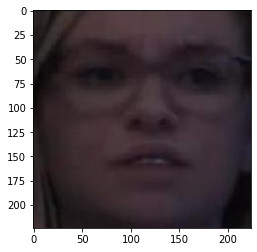

In [ ]:
img_path = os.path.join(crops_dir, np.random.choice(os.listdir(crops_dir)))
plt.imshow(cv2.imread(img_path)[..., ::-1])

In [ ]:
from torchvision.transforms import Normalize

class Unnormalize:
    """Converts an image tensor that was previously Normalize'd
    back to an image with pixels in the range [0, 1]."""
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        mean = torch.as_tensor(self.mean, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        std = torch.as_tensor(self.std, dtype=tensor.dtype, device=tensor.device).view(3, 1, 1)
        return torch.clamp(tensor*std + mean, 0., 1.)


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)
unnormalize_transform = Unnormalize(mean, std)

In [ ]:
def random_hflip(img, p=0.5):
    """Random horizontal flip."""
    if random.random() < p:
        return cv2.flip(img, 1)
    else:
        return img

In [ ]:
def load_image_and_label(filename, cls, crops_dir, image_size, augment):
    """Loads an image into a tensor. Also returns its label."""
    img = cv2.imread(os.path.join(crops_dir, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if augment: 
        img = random_hflip(img)

    img = cv2.resize(img, (image_size, image_size))

    img = torch.tensor(img).permute((2, 0, 1)).float().div(255)
    img = normalize_transform(img)

    target = 1 if cls == "FAKE" else 0
    return img, target

In [ ]:
img, target = load_image_and_label("aabuyfvwrh.jpg", "FAKE", crops_dir, 224, augment=True)
img.shape, target

(torch.Size([3, 224, 224]), 1)

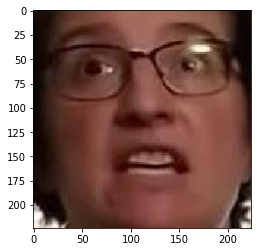

In [ ]:
plt.imshow(unnormalize_transform(img).permute((1, 2, 0)))

In [ ]:
from torch.utils.data import Dataset

class VideoDataset(Dataset):
    """Face crops dataset.

    Arguments:
        crops_dir: base folder for face crops
        df: Pandas DataFrame with metadata
        split: if "train", applies data augmentation
        image_size: resizes the image to a square of this size
        sample_size: evenly samples this many videos from the REAL
            and FAKE subfolders (None = use all videos)
        seed: optional random seed for sampling
    """
    def __init__(self, crops_dir, df, split, image_size, sample_size=None, seed=None):
        self.crops_dir = crops_dir
        self.split = split
        self.image_size = image_size
        
        if sample_size is not None:
            real_df = df[df["label"] == "REAL"]
            fake_df = df[df["label"] == "FAKE"]
            sample_size = np.min(np.array([sample_size, len(real_df), len(fake_df)]))
            print("%s: sampling %d from %d real videos" % (split, sample_size, len(real_df)))
            print("%s: sampling %d from %d fake videos" % (split, sample_size, len(fake_df)))
            real_df = real_df.sample(sample_size, random_state=seed)
            fake_df = fake_df.sample(sample_size, random_state=seed)
            self.df = pd.concat([real_df, fake_df])
        else:
            self.df = df

        num_real = len(self.df[self.df["label"] == "REAL"])
        num_fake = len(self.df[self.df["label"] == "FAKE"])
        print("%s dataset has %d real videos, %d fake videos" % (split, num_real, num_fake))

    def __getitem__(self, index):
        row = self.df.iloc[index]
        filename = row["videoname"][:-4] + ".jpg"
        cls = row["label"]
        return load_image_and_label(filename, cls, self.crops_dir, 
                                    self.image_size, self.split == "train")
    def __len__(self):
        return len(self.df)

In [ ]:
dataset = VideoDataset(crops_dir, metadata_df, "val", image_size, sample_size=1000, seed=1234)

val: sampling 1000 from 16293 real videos
val: sampling 1000 from 79341 fake videos
val dataset has 1000 real videos, 1000 fake videos


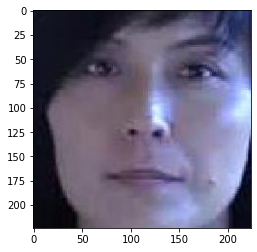

In [ ]:
plt.imshow(unnormalize_transform(dataset[0][0]).permute(1, 2, 0))

In [ ]:
del dataset

In [ ]:
def make_splits(crops_dir, metadata_df, frac):
    # Make a validation split. Sample a percentage of the real videos, 
    # and also grab the corresponding fake videos.
    real_rows = metadata_df[metadata_df["label"] == "REAL"]
    real_df = real_rows.sample(frac=frac, random_state=666)
    fake_df = metadata_df[metadata_df["original"].isin(real_df["videoname"])]
    val_df = pd.concat([real_df, fake_df])

    # The training split is the remaining videos.
    train_df = metadata_df.loc[~metadata_df.index.isin(val_df.index)]

    return train_df, val_df

In [ ]:
train_df, val_df = make_splits(crops_dir, metadata_df, frac=0.05)

assert(len(train_df) + len(val_df) == len(metadata_df))
assert(len(train_df[train_df["videoname"].isin(val_df["videoname"])]) == 0)

del train_df, val_df

In [ ]:
from torch.utils.data import DataLoader

def create_data_loaders(crops_dir, metadata_df, image_size, batch_size, num_workers):
    train_df, val_df = make_splits(crops_dir, metadata_df, frac=0.05)

    train_dataset = VideoDataset(crops_dir, train_df, "train", image_size, sample_size=16000)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                              num_workers=num_workers, pin_memory=True)

    val_dataset = VideoDataset(crops_dir, val_df, "val", image_size, sample_size=500, seed=1234)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                            num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

In [ ]:
train_loader, val_loader = create_data_loaders(crops_dir, metadata_df, image_size, 
                                               batch_size, num_workers=2)

train: sampling 15478 from 15478 real videos
train: sampling 15478 from 75449 fake videos
train dataset has 15478 real videos, 15478 fake videos
val: sampling 500 from 815 real videos
val: sampling 500 from 3892 fake videos
val dataset has 500 real videos, 500 fake videos


tensor(1)


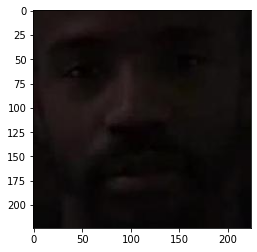

In [ ]:
X, y = next(iter(train_loader))
plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
print(y[0])

tensor(0)


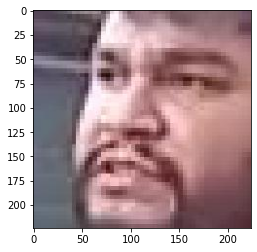

In [ ]:
X, y = next(iter(val_loader))
plt.imshow(unnormalize_transform(X[0]).permute(1, 2, 0))
print(y[0])

In [ ]:
def evaluate(net, data_loader, device, silent=False):
    net.train(False)

    bce_loss = 0
    total_examples = 0

    with tqdm(total=len(data_loader), desc="Evaluation", leave=False, disable=silent) as pbar:
        for batch_idx, data in enumerate(data_loader):
            with torch.no_grad():
                batch_size = data[0].shape[0]
                x = data[0].to(device)
                y_true = data[1].to(device).float()

                y_pred = net(x)
                y_pred = y_pred.squeeze()

                bce_loss += F.binary_cross_entropy_with_logits(y_pred, y_true).item() * batch_size

            total_examples += batch_size
            pbar.update()

    bce_loss /= total_examples

    if silent:
        return bce_loss
    else:
        print("BCE: %.4f" % (bce_loss))

In [ ]:
def fit(epochs):
    global history, iteration, epochs_done, lr

    with tqdm(total=len(train_loader), leave=False) as pbar:
        for epoch in range(epochs):
            pbar.reset()
            pbar.set_description("Epoch %d" % (epochs_done + 1))
            
            bce_loss = 0
            total_examples = 0

            net.train(True)

            for batch_idx, data in enumerate(train_loader):
                batch_size = data[0].shape[0]
                x = data[0].to(gpu)
                y_true = data[1].to(gpu).float()
                
                optimizer.zero_grad()

                y_pred = net(x)
                y_pred = y_pred.squeeze()
                
                loss = F.binary_cross_entropy_with_logits(y_pred, y_true)
                loss.backward()
                optimizer.step()
                
                batch_bce = loss.item()
                bce_loss += batch_bce * batch_size
                history["train_bce"].append(batch_bce)

                total_examples += batch_size
                iteration += 1
                pbar.update()

            bce_loss /= total_examples
            epochs_done += 1

            print("Epoch: %3d, train BCE: %.4f" % (epochs_done, bce_loss))

            val_bce_loss = evaluate(net, val_loader, device=gpu, silent=True)
            history["val_bce"].append(val_bce_loss)
            
            print("              val BCE: %.4f" % (val_bce_loss))

            # TODO: can do LR annealing here
            # TODO: can save checkpoint here

            print("")

In [ ]:
checkpoint = torch.load("/content/drive/MyDrive/resnext50_32x4d-7cdf4587.pth")

In [ ]:
import torchvision.models as models

class MyResNeXt(models.resnet.ResNet):
    def __init__(self, training=True):
        super(MyResNeXt, self).__init__(block=models.resnet.Bottleneck,
                                        layers=[3, 4, 6, 3], 
                                        groups=32, 
                                        width_per_group=4)

        self.load_state_dict(checkpoint)

        # Override the existing FC layer with a new one.
        self.fc = nn.Linear(2048, 1)

In [ ]:
net = MyResNeXt().to(gpu)

In [ ]:
del checkpoint

In [ ]:
out = net(torch.zeros((10, 3, image_size, image_size)).to(gpu))
out.shape

torch.Size([10, 1])

In [ ]:
def freeze_until(net, param_name):
    found_name = False
    for name, params in net.named_parameters():
        if name == param_name:
            found_name = True
        params.requires_grad = found_name

In [ ]:
freeze_until(net, "layer4.0.conv1.weight")

In [ ]:
[k for k,v in net.named_parameters() if v.requires_grad]

['layer4.0.conv1.weight',
 'layer4.0.bn1.weight',
 'layer4.0.bn1.bias',
 'layer4.0.conv2.weight',
 'layer4.0.bn2.weight',
 'layer4.0.bn2.bias',
 'layer4.0.conv3.weight',
 'layer4.0.bn3.weight',
 'layer4.0.bn3.bias',
 'layer4.0.downsample.0.weight',
 'layer4.0.downsample.1.weight',
 'layer4.0.downsample.1.bias',
 'layer4.1.conv1.weight',
 'layer4.1.bn1.weight',
 'layer4.1.bn1.bias',
 'layer4.1.conv2.weight',
 'layer4.1.bn2.weight',
 'layer4.1.bn2.bias',
 'layer4.1.conv3.weight',
 'layer4.1.bn3.weight',
 'layer4.1.bn3.bias',
 'layer4.2.conv1.weight',
 'layer4.2.bn1.weight',
 'layer4.2.bn1.bias',
 'layer4.2.conv2.weight',
 'layer4.2.bn2.weight',
 'layer4.2.bn2.bias',
 'layer4.2.conv3.weight',
 'layer4.2.bn3.weight',
 'layer4.2.bn3.bias',
 'fc.weight',
 'fc.bias']

In [ ]:
evaluate(net, val_loader, device=gpu)

Evaluation:   0%|          | 0/16 [00:00<?, ?it/s]

BCE: 0.7130


In [ ]:
lr = 0.01
wd = 0.

history = { "train_bce": [], "val_bce": [] }
iteration = 0
epochs_done = 0

optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

In [ ]:
fit(5)

  0%|          | 0/484 [00:00<?, ?it/s]

Epoch:   1, train BCE: 0.5607
              val BCE: 0.4991

Epoch:   2, train BCE: 0.4254
              val BCE: 0.4119

Epoch:   3, train BCE: 0.3637
              val BCE: 0.3928

Epoch:   4, train BCE: 0.3067
              val BCE: 0.4673

Epoch:   5, train BCE: 0.2677
              val BCE: 0.4370



In [ ]:
def set_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

In [ ]:
lr /= 10
set_lr(optimizer, lr)

In [ ]:
fit(5)

  0%|          | 0/484 [00:00<?, ?it/s]

Epoch:   6, train BCE: 0.1763
              val BCE: 0.4217

Epoch:   7, train BCE: 0.1396
              val BCE: 0.4416

Epoch:   8, train BCE: 0.1182
              val BCE: 0.4734

Epoch:   9, train BCE: 0.1004
              val BCE: 0.4743

Epoch:  10, train BCE: 0.0824
              val BCE: 0.5366



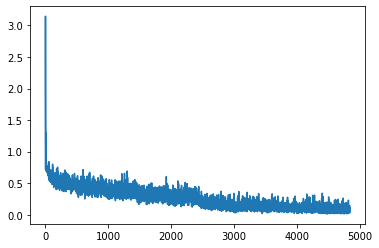

In [ ]:
plt.plot(history["train_bce"])

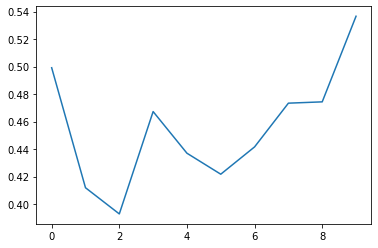

In [ ]:
plt.plot(history["val_bce"])

In [ ]:
torch.save(net.state_dict(), "checkpoint.pth")